In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge, LogisticRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import scale, StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer

%matplotlib inline
plt.style.use('ggplot')
import warnings
warnings.filterwarnings(action="ignore")

from sklearn.pipeline import Pipeline

In [ ]:
train = pd.read_csv('/home/kirill/samples/train_churn.csv')
test = pd.read_csv('/home/kirill/samples/test_churn.csv');

In [ ]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

## 1) Работа с данными

Посмотрим на пропущенные значения или пробелы в данных:

In [ ]:
print("null_data", pd.concat([train[feature_cols] , test ]).isnull().sum().sum())
print("null_target", train[target_col].isnull().mean())

# Для работы с данными
train_good = train[feature_cols]
test_good = test.copy()
pred_good = train[target_col]

# Кол-во " " в каждом столбце
for col in feature_cols:
    n = list(pd.concat([train[feature_cols] , test])[col]).count(' ')
    if (n > 0):
        print(col, n)

# Заменим пробел на медианное значение(по тренировочной выборке) для признака TotalSpent
med = np.median(train['TotalSpent'][train['TotalSpent'] != ' '].astype('float'))
train_good['TotalSpent'] = (train['TotalSpent'].replace(' ', med)).astype('float')
test_good['TotalSpent'] = (test['TotalSpent'].replace(' ', med)).astype('float')

null_data 0
null_target 0.0
TotalSpent 11


In [ ]:
agg_func_math = {
    'TotalSpent': ['mean', 'median', 'min', 'max'],
    'MonthlySpending': ['min', 'max', 'median', 'mean'],
    'ClientPeriod': ['min', 'max', 'median', 'mean']
}
test_good.join(pred_good).groupby(['Churn']).agg(agg_func_math).round(2)
train_good.join(pred_good).groupby(['Churn']).agg(agg_func_math).round(2)

TotalSpent                         MonthlySpending                 \
            mean   median   min      max             min     max median   
Churn                                                                     
0        2561.17  1709.12  18.8  8672.45           18.25  118.75  64.78   
1        1525.83   706.72  19.1  8684.80           18.95  118.35  79.50   

             ClientPeriod                    
        mean          min max median   mean  
Churn                                        
0      61.60            0  72   37.0  37.53  
1      74.28            1  72   10.0  17.95

In [ ]:
import collections
collections.Counter(list(pred_good)), np.mean(pred_good)
#Как мы видим есть дисбаланс классов, будем учитывать это при обучении

(Counter({0: 3898, 1: 1384}), 0.26202196137826583)

Создадим массив из словарей для всех категориальных признаков, каждый из которых состоит из кол-ва каждого значения этого признака.

In [ ]:
d = dict()
for i in range(len(cat_cols)):
    d[i] = dict(sorted(collections.Counter(train_good[cat_cols[i]]).items(), key=lambda item: item[1], reverse=True))
    print(cat_cols[i], d[i])

Sex {'Male': 2655, 'Female': 2627}
IsSeniorCitizen {0: 4440, 1: 842}
HasPartner {'No': 2705, 'Yes': 2577}
HasChild {'No': 3676, 'Yes': 1606}
HasPhoneService {'Yes': 4761, 'No': 521}
HasMultiplePhoneNumbers {'No': 2511, 'Yes': 2250, 'No phone service': 521}
HasInternetService {'Fiber optic': 2341, 'DSL': 1800, 'No': 1141}
HasOnlineSecurityService {'No': 2612, 'Yes': 1529, 'No internet service': 1141}
HasOnlineBackup {'No': 2332, 'Yes': 1809, 'No internet service': 1141}
HasDeviceProtection {'No': 2317, 'Yes': 1824, 'No internet service': 1141}
HasTechSupportAccess {'No': 2604, 'Yes': 1537, 'No internet service': 1141}
HasOnlineTV {'No': 2099, 'Yes': 2042, 'No internet service': 1141}
HasMovieSubscription {'No': 2081, 'Yes': 2060, 'No internet service': 1141}
HasContractPhone {'Month-to-month': 2920, 'Two year': 1280, 'One year': 1082}
IsBillingPaperless {'Yes': 3148, 'No': 2134}
PaymentMethod {'Electronic check': 1786, 'Mailed check': 1194, 'Bank transfer (automatic)': 1159, 'Credit car

Посмотрим наглядно c помощью диаграмм относительных частот:

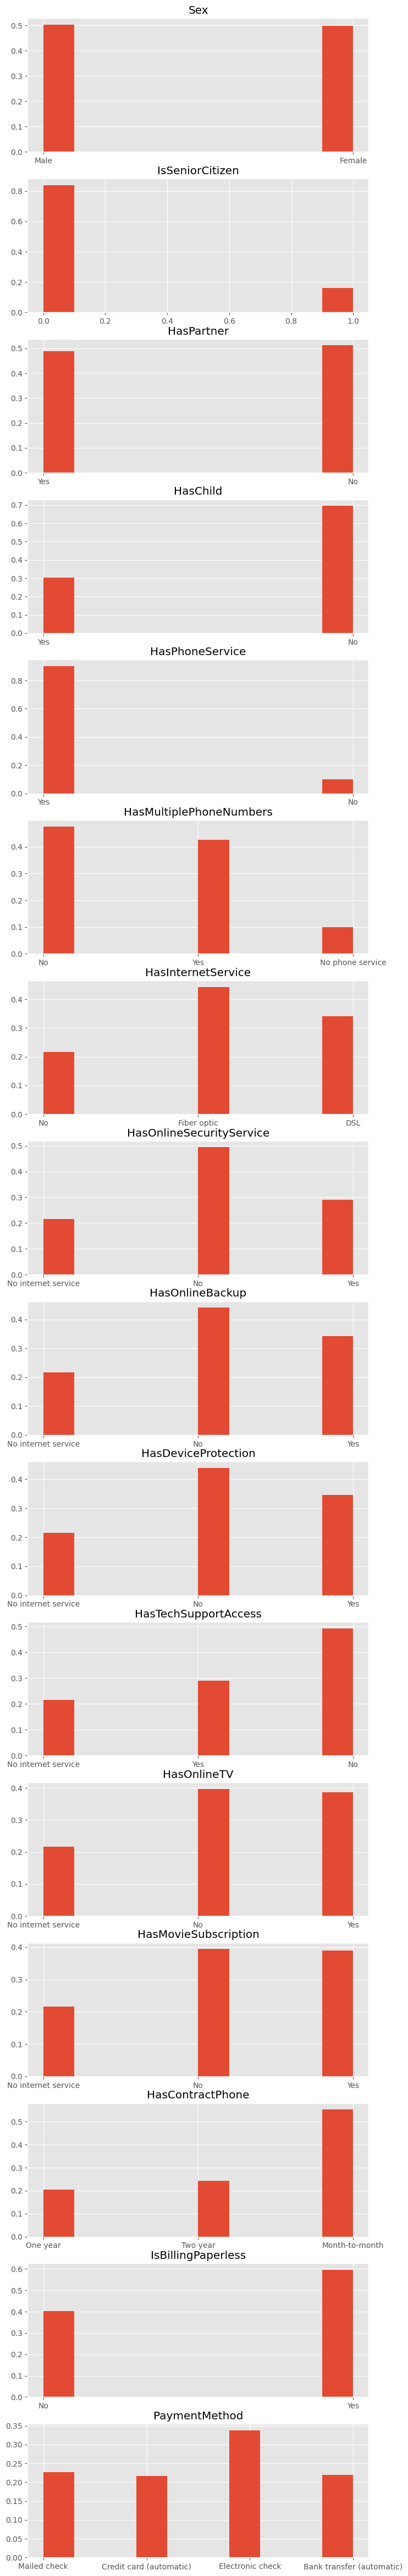

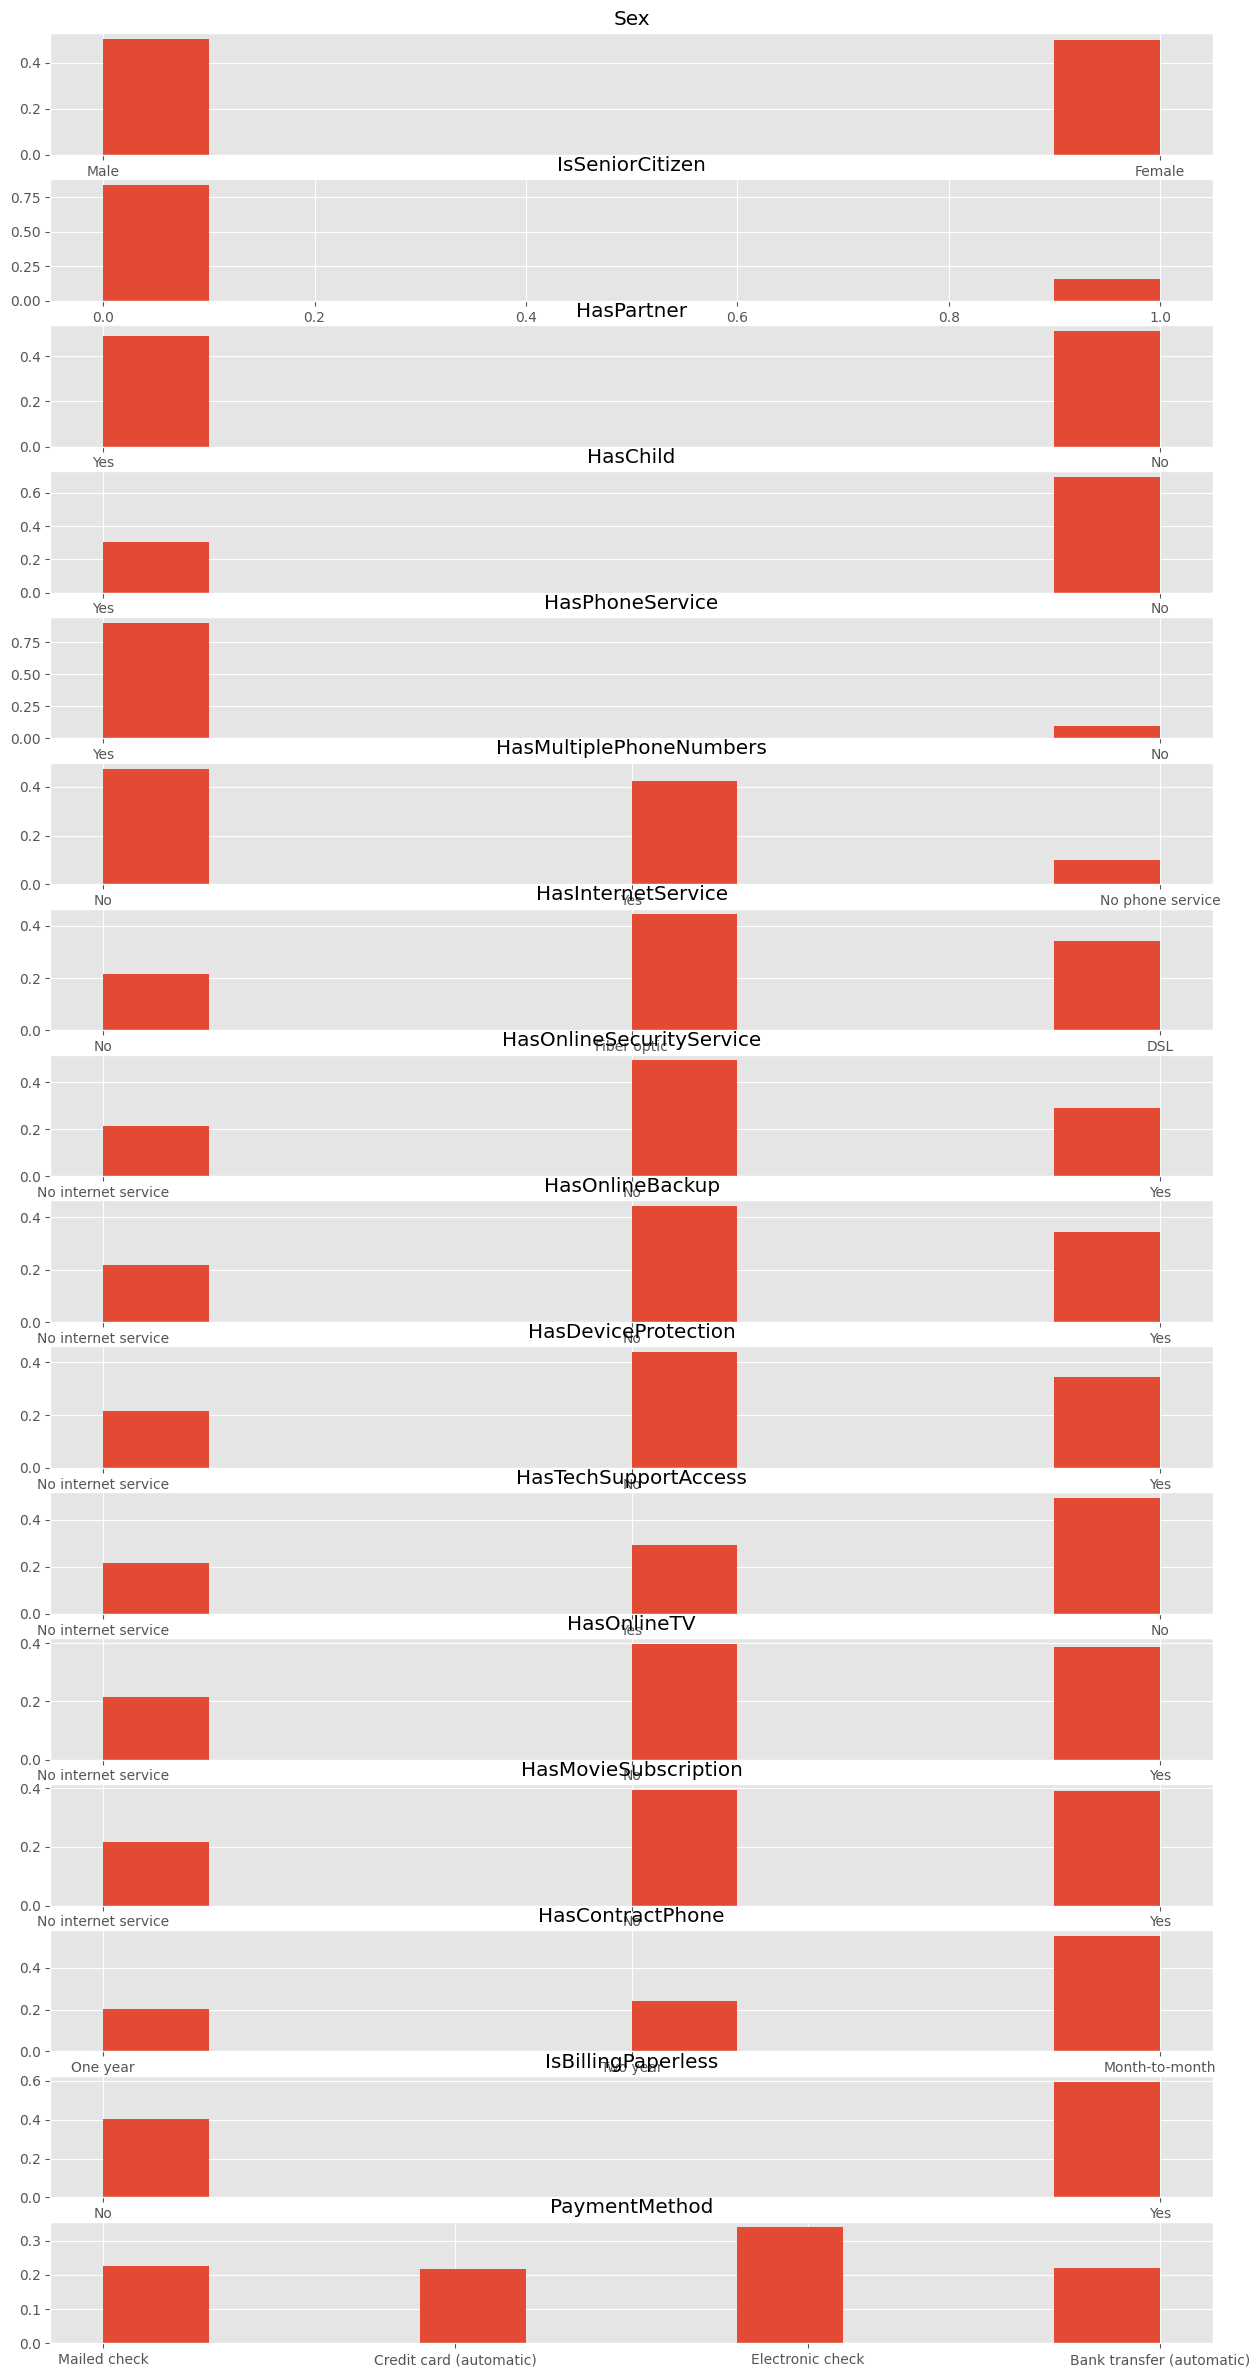

In [ ]:
fig, axs = plt.subplots(16, figsize=(8, 60))
for i in range(0,16):
    axs[i].set_title(cat_cols[i])
    axs[i].hist(train_good[cat_cols[i]], weights=np.ones_like(train_good[cat_cols[i]]) / len (train_good[cat_cols[i]]))

fig, axs = plt.subplots(16, figsize=(15, 30))
for i in range(0,16):
    axs[i].set_title(cat_cols[i])
    axs[i].hist(train_good[cat_cols[i]], weights=np.ones_like(train_good[cat_cols[i]]) / len (train_good[cat_cols[i]]))

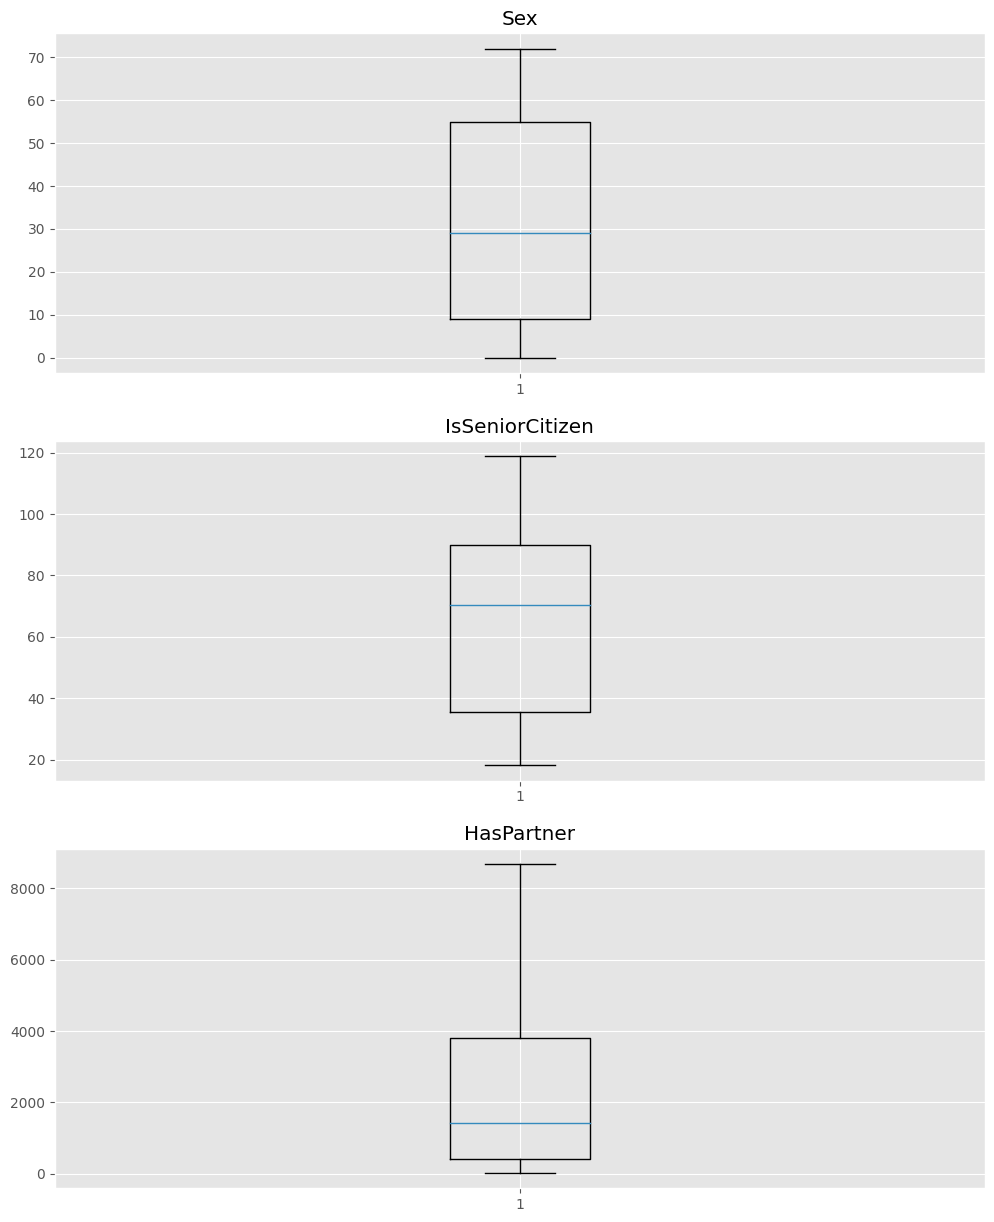

In [ ]:
fig, axs = plt.subplots(3, figsize=(12, 15))
for i in range(3):
    axs[i].set_title(nums_cols[i])
    axs[i].boxplot(train_good[num_cols[i]])

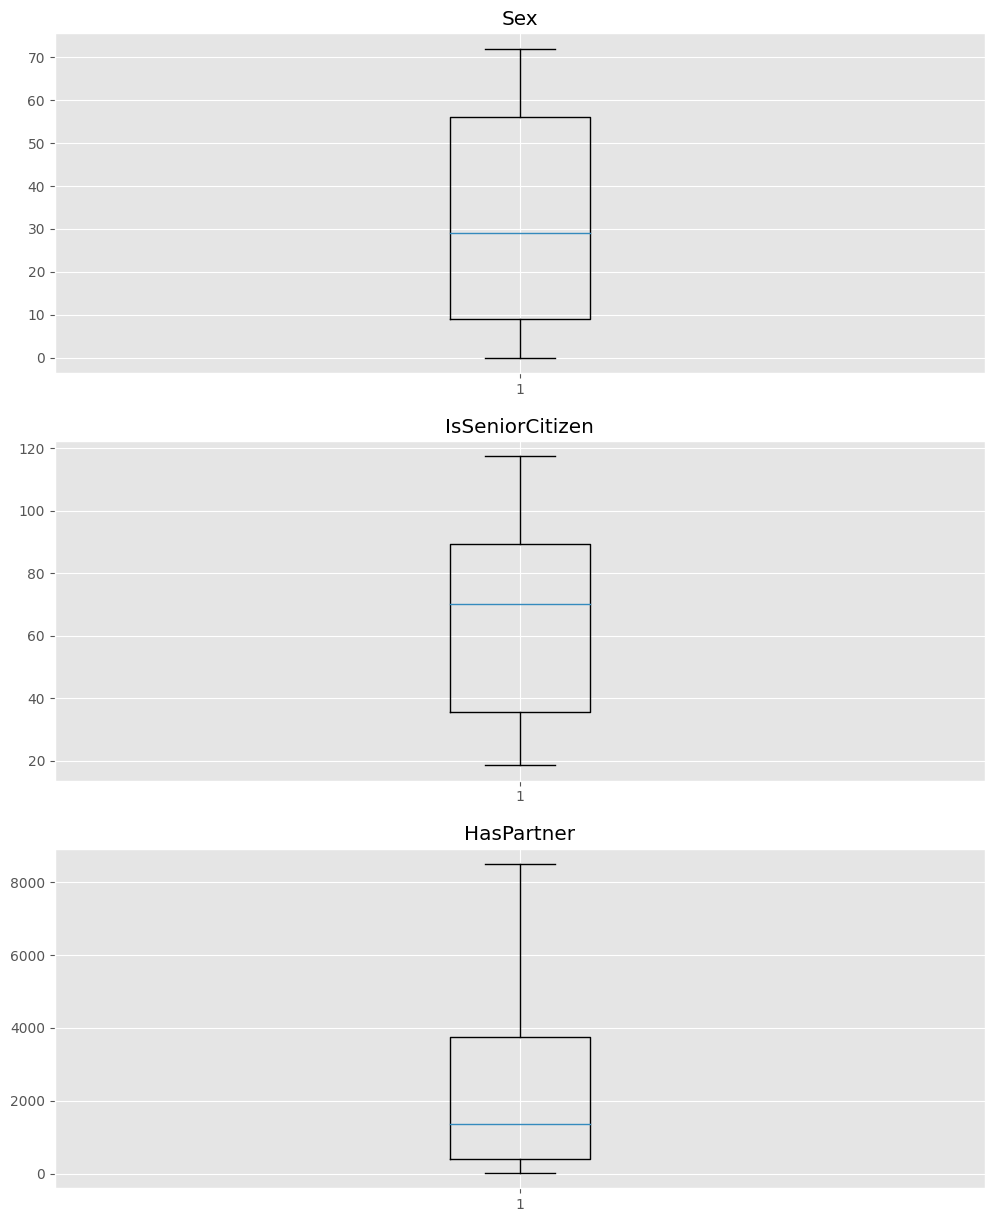

In [ ]:
# для тестовой выборки
fig, axs = plt.subplots(3, figsize=(12, 15))
for i in range(3):
    axs[i].set_title(num_cols[i])
    axs[i].boxplot(test_good[num_cols[i]])

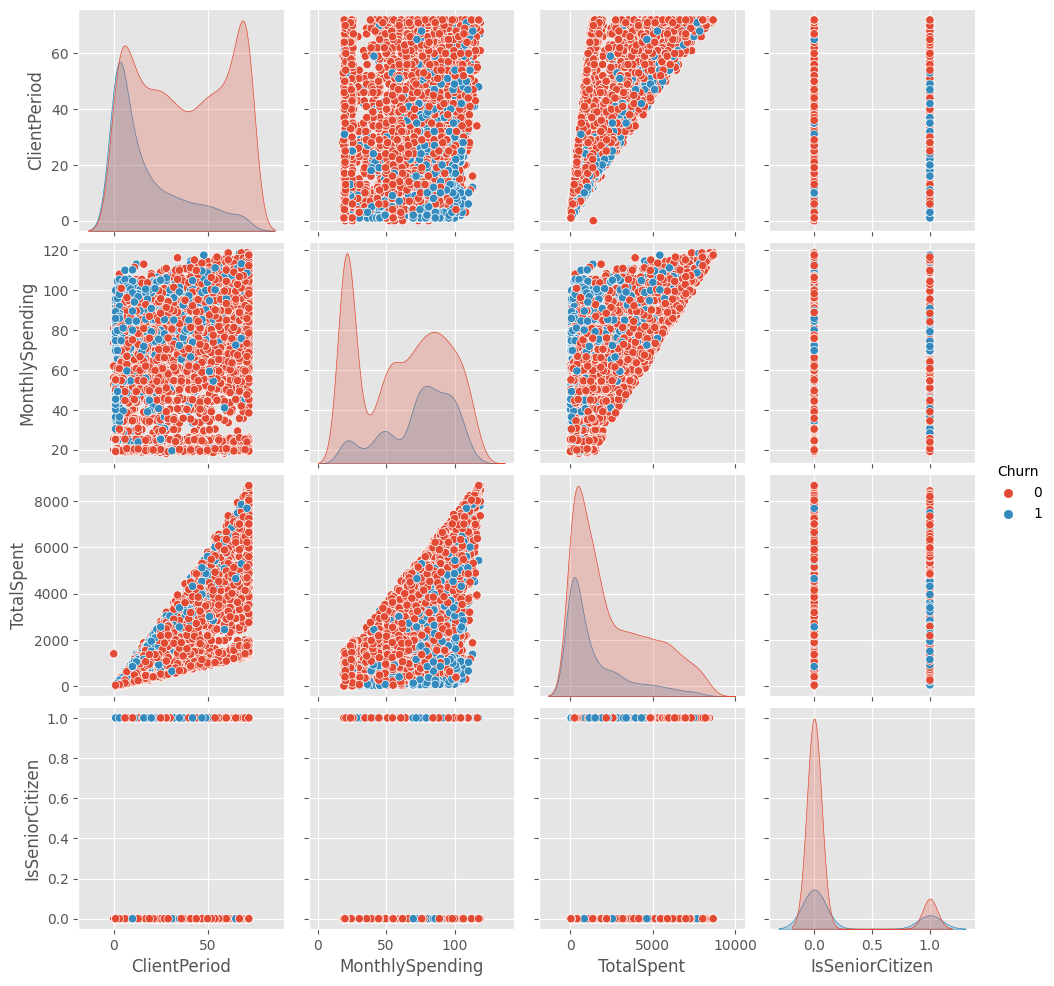

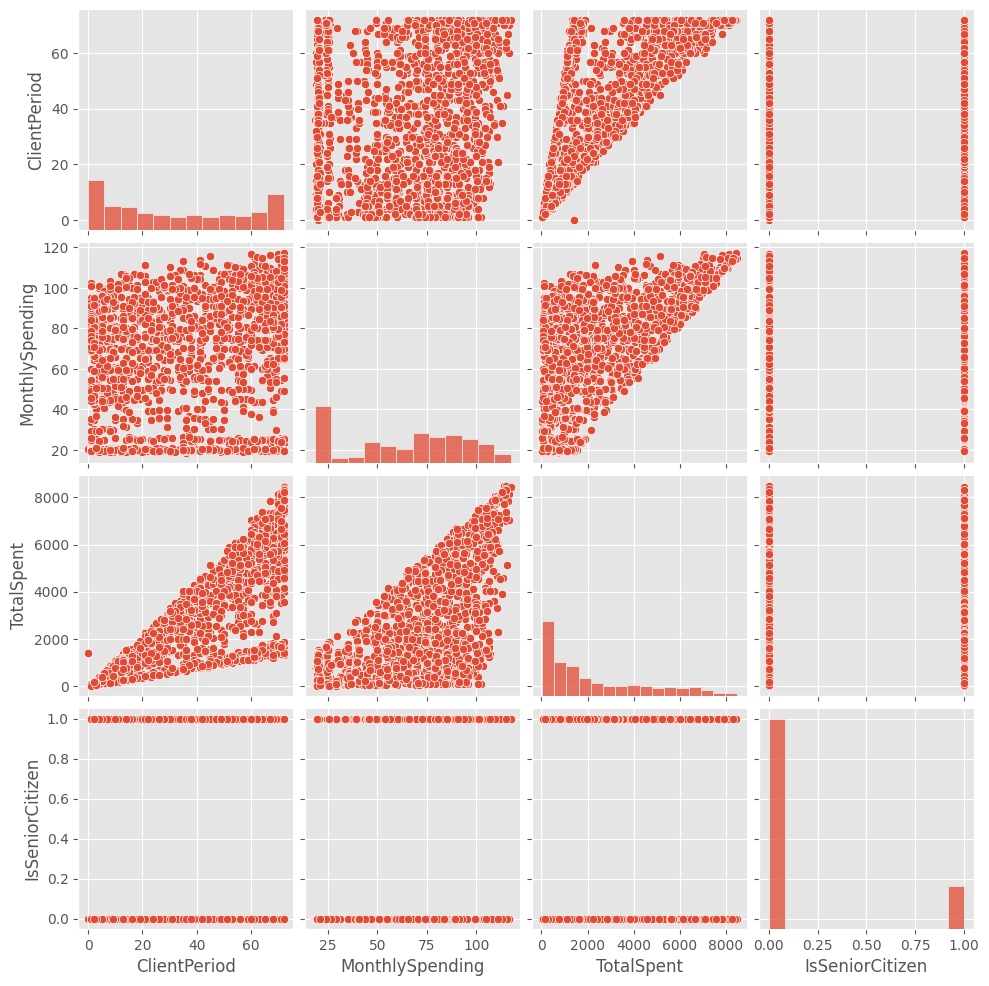

In [ ]:
sns.pairplot(train_good.join(pred_good), hue='Churn')
sns.pairplot(test_good)

Построим матрицу корреляции

In [ ]:
train_good[num_cols].corr(), test_good[num_cols].corr()

# Заметим, что TotalSpent и ClientPeriod достаточно коррелированы, можем попробовать добавить признак содержащий их произведение

(                 ClientPeriod  MonthlySpending  TotalSpent
 ClientPeriod         1.000000         0.249414    0.825871
 MonthlySpending      0.249414         1.000000    0.651838
 TotalSpent           0.825871         0.651838    1.000000,
                  ClientPeriod  MonthlySpending  TotalSpent
 ClientPeriod         1.000000         0.243305    0.824237
 MonthlySpending      0.243305         1.000000    0.647831
 TotalSpent           0.824237         0.647831    1.000000)

Как мы видим данные на тестовой и тренировочной выборк достаточно похожи. Это мы можем учитывать в дальнейшем, например, используя Target Encoding.

## 2) Линейные модели

### LogisticRegression

1. Разделим наш train на кроссвалидационную и тестовую выборки: X_train и X_test соответственно.
2. Построим пайплан из предобработки: StandartScaler и TargetCoder.
3. Проведем подборку гиперпараметров для Логистической регрессии.

In [ ]:
# добавим признак 'Total*Client'
TC = pd.DataFrame(list(map(lambda x,y : x*y, train_good['TotalSpent'], train_good['ClientPeriod'])), columns=['Total*Client'])
num_cols_T = num_cols.copy()
num_cols_T.append('Total*Client')

In [ ]:
X = train_good.join(TC)
y = pred_good

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [ ]:
preprocessing = ColumnTransformer(
    [("num", StandardScaler(), num_cols_T), ("cat", TargetEncoder(), cat_cols)]
)

pipe_log = Pipeline(
    [
        ("preprocess", preprocessing),
        ("model", LogisticRegression(random_state=10))
    ]
)

In [ ]:
param_grid = {
    "model__solver": ['lbfgs', 'liblinear', 'saga'],
    "model__penalty": ['l1', 'l2'],
    "model__C": np.linspace(10, 200, 50)
}
skf = StratifiedKFold(n_splits=5, shuffle=True)

In [ ]:
grid = GridSearchCV(
    pipe_log, param_grid=param_grid, scoring="roc_auc", cv=skf, verbose=4
)
grid.fit(X_train, y_train)

In [ ]:
grid.best_params_, grid.best_score_

({'model__C': 52.6530612244898,
  'model__penalty': 'l1',
  'model__solver': 'liblinear'},
 0.8391403319184955)

In [ ]:
## Избавляемся от '__' в ключах словаря с лучшими параметрами
def best_params(param_dict):
    return dict(map(lambda x, y: (x.split('__')[-1], y), list(param_dict.keys()), list(param_dict.values())))
best_params(grid.best_params_)

{'C': 52.6530612244898, 'penalty': 'l1', 'solver': 'liblinear'}

Построим ROC-кривую для X_train и X_test

In [ ]:
pipe_log_roc = Pipeline(
    [
        ("preprocess", preprocessing),
        ("model", LogisticRegression(random_state=10, **best_params(grid.best_params_)))
    ]
)

pipe_log_roc.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['ClientPeriod',
                                                   'MonthlySpending',
                                                   'TotalSpent',
                                                   'Total*Client']),
                                                 ('cat', TargetEncoder(),
                                                  ['Sex', 'IsSeniorCitizen',
                                                   'HasPartner', 'HasChild',
                                                   'HasPhoneService',
                                                   'HasMultiplePhoneNumbers',
                                                   'HasInternetService',
                                                   'HasOnlineSecurityService',
                                                   'HasOnlineBackup',
                                                   'HasDeviceProtection',
                                                   'HasTechSupportAccess',
                                                   'HasOnlineTV',
                                                   'HasMovieSubscription',
                                                   'HasContractPhone',
                                                   'IsBillingPaperless',
                                                   'PaymentMethod'])])),
                ('model',
                 LogisticRegression(C=52.6530612244898, penalty='l1',
                                    random_state=10, solver='liblinear'))])

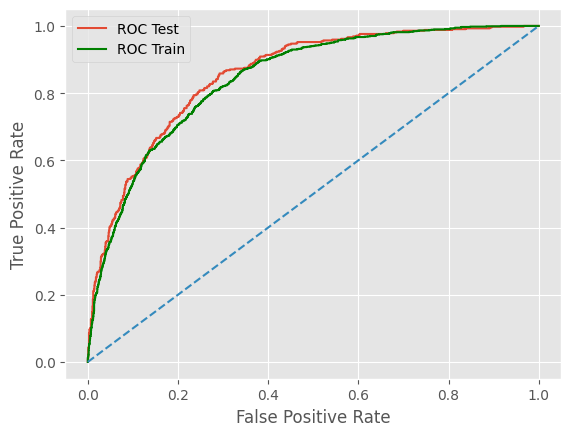

In [ ]:
fpr_test, tpr_test, treshold = roc_curve(y_test, pipe_log_roc.predict_proba(X_test)[:, 1])
fpr_train, tpr_train, treshold = roc_curve(y_train, pipe_log_roc.predict_proba(X_train)[:, 1])
plt.plot(fpr_test, tpr_test, label='ROC Test')
plt.plot(fpr_train, tpr_train, label='ROC Train', c='g')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
print("Конечный score логистической регрессии на нашей тестовой выборке:", roc_auc_score(y_test, pipe_log_roc.predict_proba(X_test)[:, 1]))

Конечный score логистической регрессии на нашей тестовой выборке: 0.8557568328898525


## 2)Градиентый бустинг

### Xgboost

In [ ]:
preprocessing = ColumnTransformer(
    [("num", StandardScaler(), num_cols_T), ("cat", TargetEncoder(), cat_cols)]
)

pipe_gb = Pipeline(
    [
        ("preprocess", preprocessing),
        ("model", XGBClassifier(random_state=10))
    ]
)

skf = StratifiedKFold(n_splits=6, shuffle=True)

In [ ]:
param_grid = {
               'model__learning_rate': np.linspace(0.1, 0.4, 3),
               'model__n_estimators': np.arange(30, 230, 5),
               'model__max_depth' : np.arange(1, 3, 1)
}

In [ ]:
gr_gb = GridSearchCV(pipe_gb, param_grid=param_grid, verbose=4, scoring='roc_auc', cv=skf)

In [ ]:
gr_gb.fit(X_train, y_train)

In [ ]:
gr_gb.best_params_, gr_gb.best_score_

({'model__learning_rate': 0.4,
  'model__max_depth': 1,
  'model__n_estimators': 85},
 0.8406043787513767)

Посмотрим на результаты модели с лучшими гиперпараметрами на нашей тестовой выборке:

In [ ]:
preprocessing = ColumnTransformer(
    [("num", StandardScaler(), num_cols_T), ("cat", TargetEncoder(), cat_cols)]
)

pipe_gb_roc = Pipeline(
    [
        ("preprocess", preprocessing),
        ("model", XGBClassifier(random_state=10, **best_params(gr_gb.best_params_)))
    ]
)

In [ ]:
pipe_gb_roc.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['ClientPeriod',
                                                   'MonthlySpending',
                                                   'TotalSpent',
                                                   'Total*Client']),
                                                 ('cat', TargetEncoder(),
                                                  ['Sex', 'IsSeniorCitizen',
                                                   'HasPartner', 'HasChild',
                                                   'HasPhoneService',
                                                   'HasMultiplePhoneNumbers',
                                                   'HasInternetService',
                                                   'HasOnlineSecurityService',
                                                   'HasOnlineBackup',
                                                   'HasDeviceProtecti...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.4,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=1, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=85,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=10, ...))])

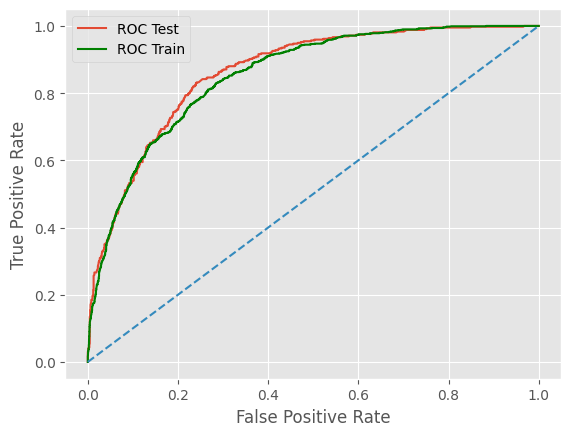

In [ ]:
fpr_test, tpr_test, treshold = roc_curve(y_test, pipe_gb_roc.predict_proba(X_test)[:, 1])
fpr_train, tpr_train, treshold = roc_curve(y_train, pipe_gb_roc.predict_proba(X_train)[:, 1])
plt.plot(fpr_test, tpr_test, label='ROC Test')
plt.plot(fpr_train, tpr_train, label='ROC Train', c='g')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
print("Конечный score Xgboost на нашей тестовой выборке:", roc_auc_score(y_test, pipe_gb_roc.predict_proba(X_test)[:, 1]))

Конечный score Xgboost на нашей тестовой выборке: 0.8627683469662626


### CatBoost

In [ ]:
cb = CatBoostClassifier(
    cat_features=cat_cols,
    eval_metric="AUC:hints=skip_train~false",
    metric_period=1000,
)
grid_params = {
    "n_estimators": np.arange(30, 240, 5),
    "learning_rate": np.linspace(0.1, 0.3, 4),
    "max_depth": np.arange(1, 4, 1),
    "l2_leaf_reg": [0.1, 0.8]
}

skf = StratifiedKFold(n_splits=6)

In [ ]:
X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(X, y, test_size=0.3)

In [ ]:
cb.grid_search(grid_params, X_train_cb, y_train_cb, cv=skf, plot=True, refit=True)

In [ ]:
best_p = {'iterations': cb.get_params().get('iterations'),
          'depth': cb.get_params().get('depth'),
          'learning_rate': cb.get_params().get('learning_rate'),
          'l2_leaf_reg': cb.get_params().get('l2_leaf_reg')
}
best_p, cb.best_score_

({'iterations': 35,
  'depth': 2,
  'learning_rate': 0.16666666666666669,
  'l2_leaf_reg': 0.1},
 {'learn': {'Logloss': 0.40837295360885356, 'AUC': 0.8511177769231002}})

In [ ]:
cb_roc = CatBoostClassifier(
    cat_features=cat_cols,
    eval_metric="AUC:hints=skip_train~false",
    metric_period=1000,
    **best_p
)

In [ ]:
cb_roc.fit(X_train_cb, y_train_cb)

0:	learn: 0.7028416	total: 1.71ms	remaining: 58.3ms
34:	learn: 0.8511178	total: 41.4ms	remaining: 0us


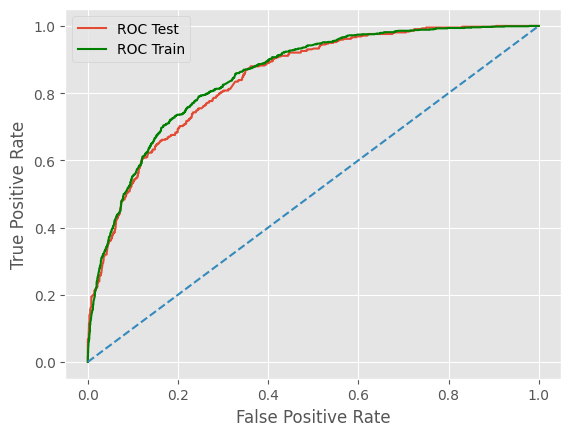

In [ ]:
fpr_test, tpr_test, treshold = roc_curve(y_test_cb, cb_roc.predict_proba(X_test_cb)[:, 1])
fpr_train, tpr_train, treshold = roc_curve(y_train_cb, cb_roc.predict_proba(X_train_cb)[:, 1])
plt.plot(fpr_test, tpr_test, label='ROC Test')
plt.plot(fpr_train, tpr_train, label='ROC Train', c='g')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
print("Конечный score Catboost на нашей тестовой выборке:", roc_auc_score(y_test_cb, cb_roc.predict_proba(X_test_cb)[:, 1]))

Конечный score Catboost на нашей тестовой выборке: 0.8421121356188721


## 3) Обучение результирующей модели

Лучший результат показал Xgboost

In [ ]:
preprocessing = ColumnTransformer(
    [("num", StandardScaler(), num_cols_T), ("cat", TargetEncoder(), cat_cols)]
)

pipe_gb = Pipeline(
    [
        ("preprocess", preprocessing),
        ("model", XGBClassifier(random_state=10))
    ]
)

skf = StratifiedKFold(n_splits=6, shuffle=True)

In [ ]:
param_grid = {
               'model__learning_rate': np.linspace(0.05, 0.6, 8),
               'model__n_estimators': np.arange(30, 350, 10),
               'model__max_depth' : np.arange(1, 5, 1)
}

In [ ]:
gr_gb = GridSearchCV(pipe_gb, param_grid=param_grid, verbose=4, scoring='roc_auc', cv=skf)

In [ ]:
gr_gb.fit(X_train, y_train)

In [ ]:
gr_gb.best_params_, gr_gb.best_score_

({'model__learning_rate': 0.3642857142857142,
  'model__max_depth': 1,
  'model__n_estimators': 90},
 0.840245121542568)

In [ ]:
preprocessing = ColumnTransformer(
    [("num", StandardScaler(), num_cols_T), ("cat", TargetEncoder(), cat_cols)]
)

pipe_gb_result = Pipeline(
    [
        ("preprocess", preprocessing),
        ("model", XGBClassifier(random_state=10, **best_params(gr_gb.best_params_)))
    ]
)

In [ ]:
best_model = pipe_gb_result.fit(X, y)

In [ ]:
TC = pd.DataFrame(list(map(lambda x,y : x*y, test_good['TotalSpent'], test_good['ClientPeriod'])), columns=['Total*Client'])

In [ ]:
pred = best_model.predict_proba(test_good.join(TC))

In [ ]:
submission = {
    'Id': np.arange(0, len(pred[:, 1])),
    'Churn': pred[:, 1]
}
solution = pd.DataFrame(submission)
solution['Id'] = solution['Id'].astype('int')
solution.to_csv('submission_churn.csv',index=False)

In [ ]:
solution

,Id,Churn
0,0,0.050719
1,1,0.675868
2,2,0.649501
3,3,0.012066
4,4,0.005079
...,...,...
1756,1756,0.127933
1757,1757,0.018032
1758,1758,0.796615
1759,1759,0.518189


Результат 0.85308 и 691 место в соревновании